# 뉴스기사 요약해보기
---

뉴스기사에 대하여 추상적 요약과 추출적 요약을 진행하여 보자!

## STEP 0. 설계
---

뉴스기사를 요약하기 위해서 다음과 같은 순서로 프로젝트를 진행 할 것이다.
1. 데이터 수집하기 : 프로젝트에 사용될 뉴스 기사 데이터를 다운로드 받는다.
2. 데이터 전처리(추상적 요약)
    - 분석
    - 정제
    - 정규화
    - 불용어 제거
    - 데이터셋 분리
    - 인코딩
3. 어텐션 메커니즘 사용하기 (추상적 요약)
    - 어텐션 메커니즘을 사용한 seq2seq를 설계
    - 모델이 성공적으로 확습 되었음을 그래프를 통하여 확인한다.
4. 실제 결과와 요약문 비교하기 (추상적 요약)
    - 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교하여 본다.
5. Summa을 이용해서 추출적 요약해보기
6. 비교
    - 두 요약 결과를 비교분석 해본다. (문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.)

## STEP 1. 데이터 수집하기
---

- enviroment setting

In [1]:
# import packages ########################################################
import nltk
# nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import tensorflow as tf

# load extensor to measure cell running time ###############################
%load_ext autotime


# set directory path# #######################################################
workspace_path = os.getenv('HOME')+'/workspace/aiffel-exploration-workspace/E11_text_summarization'
data_path = workspace_path + '/data'
# model_dir_path = workspace_path + '/models'


# initialization gpu ########################################################
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs


time: 128 ms (started: 2021-02-25 21:24:32 +09:00)


- 뉴스기사 데이터 다운로드

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="data/news_summary_more.csv")

('data/news_summary_more.csv', <http.client.HTTPMessage at 0x7ff300487950>)

time: 8.29 s (started: 2021-02-24 03:29:28 +09:00)


In [2]:
data = pd.read_csv(data_path + '/news_summary_more.csv', encoding='iso-8859-1')

time: 372 ms (started: 2021-02-25 21:24:39 +09:00)


## STEP 2. 데이터 전처리(추상적 요약)
---

### 데이터 분석

- 데이터 확인

In [3]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401
time: 1.15 ms (started: 2021-02-25 21:24:41 +09:00)


In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


time: 8.32 ms (started: 2021-02-25 21:24:42 +09:00)


In [5]:
data.columns = ['Summary', 'Text']
data.head()

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


time: 5.47 ms (started: 2021-02-25 21:24:42 +09:00)


- 원본 문장 저장

In [6]:
data['raw'] = data['Text']
data

,Summary,Text,raw
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...","Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...
...,...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si...","'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199...","According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...,A new music video shows rapper Snoop Dogg aimi...


time: 12.3 ms (started: 2021-02-25 21:24:42 +09:00)


### 중복 샘플과 NULL 값이 존재하는 샘플 제거

- 중복 제거

In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280
time: 146 ms (started: 2021-02-25 21:24:43 +09:00)


In [8]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360
time: 121 ms (started: 2021-02-25 21:24:43 +09:00)


- 결측치 제거

In [9]:
print(data.isnull().sum())

Summary    0
Text       0
raw        0
dtype: int64
time: 24.2 ms (started: 2021-02-25 21:24:43 +09:00)


결측치가 없으므로 제거하는 과정이 필요없다.

### 텍스트 정규화와 불용어 제거

- 텍스트 정규화를 위한 사전 구성

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120
time: 2 ms (started: 2021-02-25 21:24:44 +09:00)


- 불용어 제거

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

time: 2.7 ms (started: 2021-02-25 21:24:45 +09:00)


- Text 전처리 : 정규화 + 불용어 제거

In [13]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

time: 8min 11s (started: 2021-02-25 21:24:45 +09:00)


- Summary 전처리 : 정규화

In [14]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

time: 18.8 s (started: 2021-02-25 21:32:57 +09:00)


- data 업데이트

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

time: 27.6 ms (started: 2021-02-25 21:33:15 +09:00)


- 결측치 확인

In [16]:
data.isnull().sum()

Summary    0
Text       0
raw        0
dtype: int64

time: 30.5 ms (started: 2021-02-25 21:33:15 +09:00)


In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360
time: 55.1 ms (started: 2021-02-25 21:33:16 +09:00)


- 전처리된 데이터 저장 : 전처리 과정에 시간이 많이 걸리므로 전처리된 데이터를 csv로 저장하고, 이후로 새로 저장된 csv를 불러들여 프로젝트에 사용하도록 한다.

In [18]:
data.to_csv(f'{data_path}/news_summary_more_preprocessed.csv', mode='w')

time: 982 ms (started: 2021-02-25 21:33:16 +09:00)


In [19]:
data = pd.read_csv(f'{data_path}/news_summary_more_preprocessed.csv', index_col=0)
data.head()

,Summary,Text,raw
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,Kunal Shah's credit card bill payment platform...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,New Zealand defeated India by 8 wickets in the...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,"With Aegon Life iTerm Insurance plan, customer..."
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,Speaking about the sexual harassment allegatio...


time: 530 ms (started: 2021-02-25 21:33:17 +09:00)


### 데이터 정제

#### 샘플의 최대 길이 지정

- 샘플의 길이 분포 확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


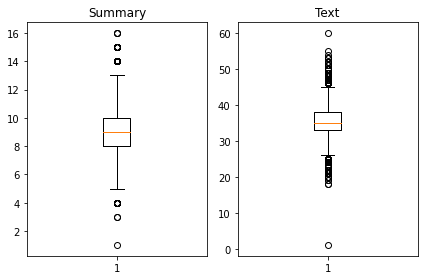

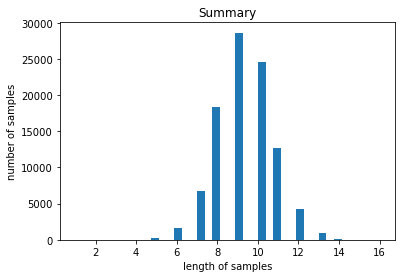

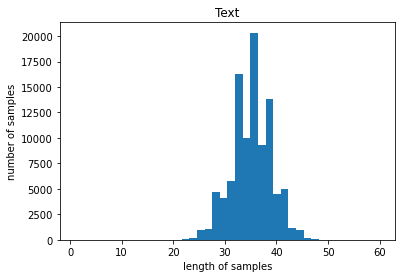

time: 800 ms (started: 2021-02-25 21:33:17 +09:00)


In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 경우 최소 길이가 1, 최대 길이가 60, 평균 길이는 35로 계산되었다. 시각화 된 그래프로 봤을 때는 대체적으로는 40 내외의 길이를 가지고 있으며 멀리서 보면 정규분포의 모양을 따르는 것처럼 보일 정도로 길이가 서로 비슷한 것을 확인 할 수 있었다.

Summary의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 길이가 짧은 것을 확인할 수 있다. 그래프에서도 대체적으로 11 이하의 길이를 가지고 있는 것을 볼 수 있다.

- 문장의 최대 길이 선정 및 통계적 확인

In [21]:
text_max_len = 40
summary_max_len = 11

time: 311 µs (started: 2021-02-25 21:33:18 +09:00)


In [22]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661
time: 249 ms (started: 2021-02-25 21:33:18 +09:00)


- 정해진 길이보다 긴 데이터 제정

In [23]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 85843
time: 254 ms (started: 2021-02-25 21:33:18 +09:00)


#### 시작/종료 토큰 추가

In [24]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,raw,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,New Zealand defeated India by 8 wickets in the...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,"With Aegon Life iTerm Insurance plan, customer...",sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,Weeks after ex-CBI Director Alok Verma told th...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


time: 45.3 ms (started: 2021-02-25 21:33:18 +09:00)


In [25]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
raw = np.array(data['raw'])

time: 4.8 ms (started: 2021-02-25 21:33:18 +09:00)


### 데이터셋 분리

- 데이터 셔플

In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[43891 81901 66916 ... 38232 79040  6375]
time: 85.5 ms (started: 2021-02-25 21:38:24 +09:00)


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
raw = raw[indices]

time: 16.8 ms (started: 2021-02-25 21:38:33 +09:00)


- 전체 데이터를 훈련 데이터와 테스트 데이터로 분리

In [37]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17168
time: 570 µs (started: 2021-02-25 21:38:34 +09:00)


In [57]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]
raw_test = raw[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))
print('테스트 원문의 개수 : ', len(raw_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168
테스트 원문의 개수 :  17168
time: 1.49 ms (started: 2021-02-25 21:42:24 +09:00)


### 정수 인코딩

#### Text

- Keras의 tokenizer를 이용하여, 훈련 데이터로부터 단어 집합 만들기

In [58]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

time: 2.03 s (started: 2021-02-25 21:42:26 +09:00)


- 등장 빈도가 낮은 단어 확인

In [59]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64681
등장 빈도가 6번 이하인 희귀 단어의 수: 44097
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20584
단어 집합에서 희귀 단어의 비율: 68.1761259102364
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.770946423361849
time: 23 ms (started: 2021-02-25 21:42:28 +09:00)


등장 빈도가 7회 미만인 단어들이 단어 집합에서 차지하는 비율은 68%인 것에 반하여, 실제 훈련 데이터에서 등장하는 빈도는 3.5%로 매우 저조한 수치를 보인다.  

- 등장 빈도가 낮은 단어 제거

In [60]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

time: 1.83 s (started: 2021-02-25 21:42:28 +09:00)


- 정수 인코딩

In [61]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[112, 1551, 2, 14, 450, 549, 1733, 554, 1, 88, 208, 1588, 5941, 405, 24, 9837, 1741, 1411, 39, 405, 1402, 1733, 450, 549, 2, 14, 148, 862, 228, 75, 347, 1195, 8683, 6655, 16977], [519, 379, 4302, 2241, 26, 400, 15, 2461, 471, 175, 2532, 104, 2461, 12620, 175, 7666, 17, 166, 9598, 31, 1259, 597, 2398, 519, 652, 251, 243], [2384, 1560, 124, 2143, 22, 781, 1130, 53, 1275, 809, 33, 2, 2143, 383, 53, 134, 289, 1919, 1476, 875, 53, 591, 548, 113, 4378, 3710, 7413, 1098, 456, 17949, 10332, 2143, 1654, 69]]
time: 1.64 s (started: 2021-02-25 21:42:30 +09:00)


#### Summary

- Keras의 tokenizer를 이용하여, 훈련 데이터로부터 단어 집합 만들기

In [62]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

time: 778 ms (started: 2021-02-25 21:42:32 +09:00)


- 등장 빈도가 낮은 단어 확인

In [63]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28559
등장 빈도가 5번 이하인 희귀 단어의 수: 18825
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9734
단어 집합에서 희귀 단어의 비율: 65.91617353548793
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.17544603889278
time: 9.65 ms (started: 2021-02-25 21:42:32 +09:00)


- 등장 빈도가 낮은 단어 제거 및 정수 인코딩

In [64]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 148, 8184, 674, 522, 4245, 194, 6, 5936, 139, 1833], [1, 278, 1273, 270, 2743, 4402, 37, 436, 67], [1, 1089, 3, 806, 14, 27, 13, 1687], [1, 61, 8185, 134, 7, 1136, 1688, 10, 8855], [1, 638, 6291, 6292, 8856, 27, 3, 159, 444, 33]]
target
decoder  [[148, 8184, 674, 522, 4245, 194, 6, 5936, 139, 1833, 2], [278, 1273, 270, 2743, 4402, 37, 436, 67, 2], [1089, 3, 806, 14, 27, 13, 1687, 2], [61, 8185, 134, 7, 1136, 1688, 10, 8855, 2], [638, 6291, 6292, 8856, 27, 3, 159, 444, 33, 2]]
time: 3.55 s (started: 2021-02-25 21:42:32 +09:00)


- Summary의 길이가 1인 데이터 모두 삭제

In [65]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)
raw_test = np.delete(raw_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))
print('테스트 원문의 개수 :', len(raw_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168
테스트 원문의 개수 : 17168
time: 228 ms (started: 2021-02-25 21:42:36 +09:00)


### 패딩

In [66]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

time: 1.08 s (started: 2021-02-25 21:42:41 +09:00)


In [67]:
print(f'encoder_input_train.shape : {encoder_input_train.shape}')
print(f'encoder_input_test.shape : {encoder_input_test.shape}')
print(f'decoder_input_train.shape : {decoder_input_train.shape}')
print(f'decoder_target_train.shape : {decoder_target_train.shape}')
print(f'decoder_input_test.shape : {decoder_input_test.shape}')
print(f'decoder_target_test.shape : {decoder_target_test.shape}')

encoder_input_train.shape : (68674, 40)
encoder_input_test.shape : (17168, 40)
decoder_input_train.shape : (68674, 11)
decoder_target_train.shape : (68674, 11)
decoder_input_test.shape : (17168, 11)
decoder_target_test.shape : (17168, 11)
time: 889 µs (started: 2021-02-25 21:42:42 +09:00)


## STEP 3. 어텐션 메커니즘 사용하기 (추상적 요약)
---

### 모델 설계

- 인코더

In [68]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.config.experimental_run_functions_eagerly(True)
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# recurrent_dropout = 0.4 raise warn ---> WARNING:tensorflow:Layer lstm_3 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria.
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

time: 753 ms (started: 2021-02-25 21:42:42 +09:00)


- 디코더

In [69]:
from attention import AttentionLayer

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])
                                                               
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
                                                               
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 128)      2560000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 40, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [70]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
269/269 [==============================] - 51s 190ms/step - loss: 6.0410 - val_loss: 5.6321
Epoch 2/50
269/269 [==============================] - 51s 191ms/step - loss: 5.4857 - val_loss: 5.2977
Epoch 3/50
269/269 [==============================] - 51s 191ms/step - loss: 5.1282 - val_loss: 4.9833
Epoch 4/50
269/269 [==============================] - 52s 193ms/step - loss: 4.8395 - val_loss: 4.7908
Epoch 5/50
269/269 [==============================] - 51s 191ms/step - loss: 4.6130 - val_loss: 4.6306
Epoch 6/50
269/269 [==============================] - 52s 195ms/step - loss: 4.4294 - val_loss: 4.5027
Epoch 7/50
269/269 [==============================] - 52s 192ms/step - loss: 4.2663 - val_loss: 4.4128
Epoch 8/50
269/269 [==============================] - 51s 191ms/step - loss: 4.1232 - val_loss: 4.3183
Epoch 9/50
269/269 [==============================] - 51s 191ms/step - loss: 3.9947 - val_loss: 4.2592
Epoch 10/50
269/269 [==============================] - 52s 192ms/step - l

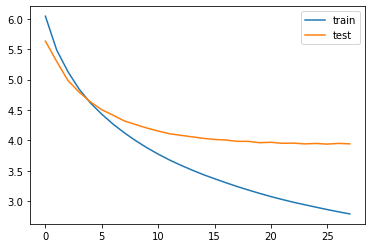

time: 144 ms (started: 2021-02-25 22:12:15 +09:00)


In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 모델 저장 : 학습된 모델을 저장하고 이후의 동작은 저장된 모델을 불러와 진행한다.

In [72]:
model.save(f'{workspace_path}/model_40_11_2.h5')

time: 139 ms (started: 2021-02-25 22:12:21 +09:00)


In [42]:
model_v4 = model

time: 304 µs (started: 2021-02-25 12:17:10 +09:00)


- 모델 불러오기

In [119]:
from tensorflow.keras.models import load_model
from attention import AttentionLayer

model = load_model(f'{workspace_path}/model_3.h5', custom_objects={'AttentionLayer':AttentionLayer})

time: 1.2 s (started: 2021-02-25 13:20:12 +09:00)


## STEP 4. 실제 결과와 요약문 비교하기 (추상적 요약)
---

### 인퍼런스 모델 생성

- 데이터 복원을 위한 사전 정의

In [73]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

time: 636 µs (started: 2021-02-25 22:12:28 +09:00)


- 인퍼런스 모델 설계

In [74]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

time: 373 ms (started: 2021-02-25 22:12:28 +09:00)


- 인퍼런스 단계에서 단어 스퀀스를 완성하는 함수

In [75]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c
                
    return decoded_sentence

time: 1.14 ms (started: 2021-02-25 22:12:29 +09:00)


### 추상적 요약 진행

In [76]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

time: 930 µs (started: 2021-02-25 22:12:29 +09:00)


- 요약 성능 평가를 위하여 ROUGE F1 score를 도입한다.

In [77]:
from functools import reduce
def count_overlapped_words(str1, str2):
    str1_unique_words = set(str1.split())
    return reduce(lambda acc, cur: acc+1 if cur in str1_unique_words else acc, \
                  str2.split(), 0)

time: 961 µs (started: 2021-02-25 22:12:34 +09:00)


In [78]:
def get_rouge_f1_score(refer_summary, system_summary):
    refer_summary = refer_summary.strip()
    system_summary = system_summary.strip()
    
    if not refer_summary or not system_summary:
        return -1
    
    number_of_overlapped_words = count_overlapped_words(refer_summary, system_summary)

    # recall
    # number_of_overlapped_words / total_words_in_reference_summary
    recall = number_of_overlapped_words / len(refer_summary.split())
    
    
    # precision
    # number_of_overlapped_words / total_words_in_system_summay
    precision = number_of_overlapped_words / len(system_summary.split())
    
    if recall == 0 and precision == 0:
        return 0 
    
    # f1
    # 2 * (precision * recall) / (precision + recall)
    try:
        f1 = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1 = 0
        
    return f1

time: 770 µs (started: 2021-02-25 22:12:35 +09:00)


- 테스트 셋에 대한 rouge f1 계산

In [80]:
print(decoder_input_test[0])
print(encoder_input_test[0].reshape(1, text_max_len))

[   1 1453  528  801   92   93  196    4 9694    0    0]
[[   12   130   474 14399 10888  2171  1272  1420   323  8753    55    84
    257  2348   585 17904  3476    74     1   976  1890   611  5154  1193
   2181  1602   585   950  2082 11840  1565     0     0     0     0     0
      0     0     0     0]]
time: 1.02 ms (started: 2021-02-25 22:12:43 +09:00)


In [56]:
from tqdm import tqdm

f1_acc = 0

for i in tqdm(range(len(encoder_input_test))):
    refer_summary = seq2summary(decoder_input_test[i])
    system_summary = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    f1_score = get_rouge_f1_score(refer_summary, system_summary)
    f1_acc += f1_score
    
abstrace_rouge_f1_score = f1_acc / len(encoder_input_test)
print(f'ROUGE F1 SCORE : {abstrace_rouge_f1_score}')

100%|██████████| 17168/17168 [2:07:32<00:00,  2.24it/s]  

ROUGE F1 SCORE : 0.2810423389849427
time: 2h 7min 32s (started: 2021-02-25 14:51:09 +09:00)


- 랜덤한 샘플 추출

In [96]:
import random
idxs = random.sample(range(0, len(encoder_input_test)), 20)

def get_summary_report_form():
    return {
        'raw' : "",
        'reference' : "",
        'abstract' : "",
        'f1_abstract' : 0,
        'extract' : "",
        'f1_extract': 0
    }

time: 592 µs (started: 2021-02-25 22:22:40 +09:00)


In [97]:
from tqdm import tqdm

summary_report = []

for i in tqdm(idxs):
    preprocessed = seq2text(encoder_input_test[i])
    refer_summary = seq2summary(decoder_input_test[i])
    system_summary = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    f1_score = get_rouge_f1_score(refer_summary, system_summary)
    
    report_form = get_summary_report_form()
    report_form['raw'] = raw_test[i]
    report_form['reference'] = refer_summary
    report_form['abstract'] = system_summary
    report_form['f1_abstract'] = f1_score
    
    summary_report.append(report_form)

100%|██████████| 20/20 [00:07<00:00,  2.68it/s]

time: 7.45 s (started: 2021-02-25 22:22:41 +09:00)


- 혹시 모를 경우를 대비햐여 `summary_report`를 pickle로 저장해두자.

In [148]:
import pickle

with open(workspace_path + "/summary_report/report_1.pickle","wb") as fw:
    pickle.dump(summary_report, fw)

time: 1.08 ms (started: 2021-02-25 18:09:54 +09:00)


In [364]:
with open(workspace_path + "/summary_report/report_1.pickle","rb") as fr:
    pickle_load_test = pickle.load(fr)
pickle_load_test[3]

{'raw': '',
 'reference': 'no change in law for visa system remains the same us ',
 'abstract': ' us state secy calls for us president trump',
 'f1_abstract': 0.3157894736842105,
 'extract': '',
 'f1_extract': 0}

time: 2.23 ms (started: 2021-02-25 21:15:32 +09:00)


## STEP 5. Summa을 이용해서 추출적 요약해보기
---

- 실험 결과 `summa.summarizer.summarize`는 전처리된 문장에 대해서는 요약을 제대로 수행하지 못하였다. 이에 대한 대안으로 정제되지 않은 원본 데이터를 요약에 사용하였고 정상적으로 함수가 작동하는 것을 확인할 수 있었다.

In [100]:
from summa.summarizer import summarize

summarized_str = 0
f1_acc = 0
summarize_fail_cnt = 0

for i in tqdm(range(len(encoder_input_test))):
    raw = raw_test[i]
    
    ratio = 0.2
    summarized_str = summarize(raw, ratio=ratio)
    while ratio < 7 and not summarized_str:
        ratio += 0.05
        summarized_str = summarize(raw, ratio=ratio)
    
    if not summarized_str:
        summarize_fail_cnt += 1
        
    refer_summary = seq2summary(decoder_input_test[i])
    f1_score = get_rouge_f1_score(refer_summary, summarized_str)
    if f1_score > 0 : f1_acc += f1_score

    
summary_rouge_f1_score = f1_acc / len(encoder_input_test)
print(f'ROUGE F1 SCORE : {summary_rouge_f1_score}')
print(f'Summary Failure : {(summarize_fail_cnt / len(encoder_input_test))*100}')

100%|██████████| 17168/17168 [01:56<00:00, 147.51it/s]

ROUGE F1 SCORE : 0.1839122049345609
Summary Failure : 2.4347623485554517
time: 1min 56s (started: 2021-02-25 22:26:56 +09:00)


- summary_report update

In [119]:
for i in tqdm(range(len(summary_report))):
    ratio = 0.2
    summarized_str = summarize(summary_report[i]['raw'], ratio=ratio)
    while ratio < 7 and not summarized_str:
        ratio += 0.05
        summarized_str = summarize(summary_report[i]['raw'], ratio=ratio)
        
    refer_summary = seq2summary(decoder_input_test[i])
    f1_score = get_rouge_f1_score(summary_report[i]['reference'], summarized_str)
    
    summary_report[i]['extract'] = summarized_str
    summary_report[i]['f1_extract'] = f1_score

100%|██████████| 20/20 [00:00<00:00, 220.29it/s]

time: 92.9 ms (started: 2021-02-25 22:51:57 +09:00)


## STEP 6. 추상적 요약 vs 추출적 요약
---

In [121]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

def left_align(df):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

for i, report in enumerate(summary_report):
    df = pd.DataFrame(report, index=[i]).T
    df = left_align(df)
    display(df)

,0
raw,"Radhika Apte has revealed she had to engage in phone sex during her audition for the film 'Dev D'. ""By that time I never had phone sex and...I had to do it in front of everybody,"" she added while talking about her ""craziest audition"". However, Radhika said it was ""great"" auditioning for the film even though she didn't get selected."
reference,had to in phone sex during dev audition radhika
abstract,was sexually harassed by producer on nude scene
f1_abstract,0
extract,Radhika Apte has revealed she had to engage in phone sex during her audition for the film 'Dev D'.
f1_extract,0.500000


,1
raw,"French tennis player Benoit Paire smashed three racquets in his loss to Cyprus' Marcos Baghdatis in their Citi Open match on Tuesday. After falling down at the end of a point in the match, Paire sat on the court and smashed his racquet four times on the court. At one point, Baghdatis went over to Paire to talk to him."
reference,french tennis player smashes in one match
abstract,player once played out of match during match match
f1_abstract,0.500000
extract,"After falling down at the end of a point in the match, Paire sat on the court and smashed his racquet four times on the court."
f1_extract,0.060606


,2
raw,"Google has launched the 'Two-wheeler' mode on Maps in India, a feature which will show the fastest route and directions to two-wheeler riders to reach their entered destination. The feature will be available alongside the 'Drive', 'Train or Bus', and 'Walk' options. The 'Two-wheeler' mode is currently available on Android smartphones."
reference,google brings two wheeler mode to maps in india
abstract,google maps to launch india location in maps
f1_abstract,0.705882
extract,The 'Two-wheeler' mode is currently available on Android smartphones.
f1_extract,0.111111


,3
raw,"Online retailer Asos has been trolled by social media users for introducing a pair of 'buttless jeans'. A user tweeted, ""One question...... why?"" ""May as well not bother wearing them,"" commented another user. ""Asos what are you thinking? Maybe you're not thinking very well,"" read another comment. Meanwhile, another user wrote, ""Why wear anything?"""
reference,trolled for jeans
abstract,twitter users react to show videos of making users
f1_abstract,0
extract,"why?"" ""May as well not bother wearing them,"" commented another user."
f1_extract,0


,4
raw,"A 25-year-old man kidnapped and killed his 17-year-old cousin for a ranson of Ã¢ÂÂ¹1 crore. The accused had lured his cousin by promising to buy him a computer game and later also tried convincing the boy's father to not inform the police. However, the father called the police, following which the man ordered his aides to kill the boy."
reference,man and kills minor cousin for crore ransom
abstract,year old man killed by buy men for cr
f1_abstract,0.235294
extract,"However, the father called the police, following which the man ordered his aides to kill the boy."
f1_extract,0.080000


,5
raw,"Slamming US President Donald Trump's policy to separate children of illegal immigrants from their families, Nobel Peace Prize laureate Malala Yousafzai described it as ""cruel"". ""This is unfair and this is inhumane. I don't know how anyone could do that,"" she said. Malala further said, ""I hope that the children can be together with their parents."""
reference,malala slams trump cruel child separation policy
abstract,trump defends us prez for calling children
f1_abstract,0.142857
extract,"Malala further said, ""I hope that the children can be together with their parents."""
f1_extract,0


,6
raw,"Speaking about the controversy around his biography 'An Ordinary Life: A Memoir', actor Nawazuddin Siddiqui said, ""If and when I write something after 10-12 years, I'll write only lies."" ""I wrote the truth. I wrote about my struggles, my life, the mistakes I made...But it backfired,"" he added. Nawazuddin had revealed personal details about his past relationships in his biography."
reference,will write only lies the next time nawazuddin on biography
abstract,my family is good good actor nawazuddin
f1_abstract,0.117647
extract,"Speaking about the controversy around his biography 'An Ordinary Life: A Memoir', actor Nawazuddin Siddiqui said, ""If and when I write something after 10-12 years, I'll write only lies."" ""I wrote the truth."
f1_extract,0.279070


,7
raw,"The Chinese government is recruiting 20,000 people to write an online encyclopedia like Wikipedia. The scholars will reportedly write more than 3,00,000 entries of about 1,000 words apiece spanning over 100 disciplines. The resource will reportedly have information on China's technological developments and historical heritage to ""strengthen the core values of socialism.Ã¢ÂÂ"
reference,china to hire people to write wikipedia like
abstract,china releases language of
f1_abstract,0.166667
extract,"The scholars will reportedly write more than 3,00,000 entries of about 1,000 words apiece spanning over 100 disciplines."
f1_extract,0.076923


,8
raw,"An international team of astronomers analysing 355 multi-planet systems have found that exoplanets orbiting the same star tend to have similar sizes and a regular orbital spacing like ""peas in a pod"". However, in our Solar System, the inner planets are diversely sized and have large spacing, probably because Jupiter and Saturn disrupted our system's early structure, researchers said."
reference,other star systems more ordered than our solar system study
abstract,nasa finds new planet to earth planet for planet
f1_abstract,0
extract,"An international team of astronomers analysing 355 multi-planet systems have found that exoplanets orbiting the same star tend to have similar sizes and a regular orbital spacing like ""peas in a pod""."
f1_extract,0.095238


,9
raw,"State-run telecom firm BSNL has signed a deal with Japan's SoftBank and NTT Communications to launch 5G internet service and Internet of Things technology in India, BSNL Chairman Anupam Shrivastava said. ""Under the agreement, we will look at solution specially for the smart cities,"" he added. He also said that the service may launch by 2020 in the country."
reference,bsnl signs deal with softbank to roll out in india
abstract,will launch startups in future startups
f1_abstract,0.125000
extract,"State-run telecom firm BSNL has signed a deal with Japan's SoftBank and NTT Communications to launch 5G internet service and Internet of Things technology in India, BSNL Chairman Anupam Shrivastava said."
f1_extract,0.195122


,10
raw,"Weapons belonging to India's shooting team were seized by the customs department at Delhi airport on Tuesday, with the shooters being detained for over 13 hours. The shooters, which included a few Olympians returning from the Plzen Grand Prix, were reportedly clueless about the reason for detention. They also alleged the customs officials used foul language with them."
reference,weapons of india shooting team seized at delhi airport
abstract,saudi arabia seizes man who killed in delhi
f1_abstract,0.117647
extract,"Weapons belonging to India's shooting team were seized by the customs department at Delhi airport on Tuesday, with the shooters being detained for over 13 hours."
f1_extract,0.285714


,11
raw,"Sahara Group Chairman Subrata Roy's son, Seemanto Roy, has been removed as a director of Sahara Housingfina Corporation, the company announced on Wednesday. It said that Roy was enlisted in a government notification pertaining to disqualification of directors who have defaulted in filing financial results for preceding three fiscals. Notably, the government has disqualified 3.09 lakh directors."
reference,roy son sacked as director after govt notice
abstract,mistry chairman mehta gets shareholders approval to sahara
f1_abstract,0
extract,It said that Roy was enlisted in a government notification pertaining to disqualification of directors who have defaulted in filing financial results for preceding three fiscals.
f1_extract,0


,12
raw,"The Supreme Court on Wednesday dismissed all petitions filed by students and parents over the recent CBSE paper leak. It refused to interfere in the CBSE's decision to hold a re-examination for the Class 12 Economics paper and dismissed a plea for a CBI inquiry into the leak. ItÃ¢ÂÂs for the authorities to look into the matter, the court said."
reference,sc dismisses all filed over cbse paper leak
abstract,sc orders cbse to cbse board exam paper leak
f1_abstract,0.588235
extract,The Supreme Court on Wednesday dismissed all petitions filed by students and parents over the recent CBSE paper leak.
f1_extract,0.296296


,13
raw,"Addressing a kisan rally in Uttar Pradesh's Shahjahanpur on Saturday, PM Narendra Modi said the Opposition was shedding crocodile tears and ""had no time to work on MSP hike"". ""[Our] priority is to ensure that the hard work of the farmers of this nation is respected. That's the reason several decisions have been taken to benefit sugarcane farmers,"" he added."
reference,opposition crocodile tears pm at rally in up
abstract,pm modi calls govt govt for lok sabha
f1_abstract,0.125000
extract,"""[Our] priority is to ensure that the hard work of the farmers of this nation is respected."
f1_extract,0


,14
raw,"The Secretary of Iran's Supreme National Security Council, Ali Shamkhani, on Friday said that the US is ""seeking excuses"" to tear up the 2015 nuclear deal with the country by demanding military site inspections. Adding that Iran has no undisclosed nuclear activity in any geographical location, Shamkhani said that issues being raised by the US are media hype."
reference,us seeking to destroy nuclear deal iran
abstract,iran denies report of nuclear deal with us
f1_abstract,0.533333
extract,"The Secretary of Iran's Supreme National Security Council, Ali Shamkhani, on Friday said that the US is ""seeking excuses"" to tear up the 2015 nuclear deal with the country by demanding military site inspections."
f1_extract,0.146341


,15
raw,"The National Aquarium of New Zealand has gone viral for its Facebook post naming its ""naughty"" and ""good"" penguins of the month. The aquarium said Timmy was the naughty penguin in June because he stole fish and pushed another penguin, while Betty was good because she waited patiently for fish. It houses little penguins with serious injuries or disabilities."
reference,new zealand names and penguin
abstract,nz player suspended for having food at home
f1_abstract,0
extract,"The National Aquarium of New Zealand has gone viral for its Facebook post naming its ""naughty"" and ""good"" penguins of the month."
f1_extract,0.074074


,16
raw,"Over 150 former prisoners were offered jobs at a Telangana prisons department's recruitment drive which saw participation from firms like Flipkart, Swiggy, Karvy and HDFC. The former inmates, which included murder convicts, were hired as marketing executives, delivery boys, security guards, computer operators, medical attendants and detective agents. The salaries ranged from Ã¢ÂÂ¹8,000 to Ã¢ÂÂ¹18,000."
reference,flipkart swiggy among firms offering jobs to ex prisoners
abstract,former mp launches campaign to kill ex ceo
f1_abstract,0.235294
extract,"Over 150 former prisoners were offered jobs at a Telangana prisons department's recruitment drive which saw participation from firms like Flipkart, Swiggy, Karvy and HDFC."
f1_extract,0.176471


,17
raw,"The Indonesian town of Kampung Pelangi has been repainted in bright colours and decorated with 3D murals, as part of a Ã¢ÂÂ¹14.4 lakh government-funded makeover. Once considered a slum, the town has started attracting tourists. According to reports, the local government is investing more money to clean up the river and expand the project."
reference,indonesian town painted in bright colours
abstract,german village turns out of island
f1_abstract,0
extract,"The Indonesian town of Kampung Pelangi has been repainted in bright colours and decorated with 3D murals, as part of a Ã¢ÂÂ¹14.4 lakh government-funded makeover."
f1_extract,0.258065


,18
raw,"Authorities have arrested the suspect who fatally shot Indian-origin police officer Ronil Singh earlier this week in California, US. The suspect, Gustavo Perez Arriaga, was in the US illegally and was arrested as he tried to flee back to Mexico. Seven other people who misled the authorities about his whereabouts or aided him in fleeing were also arrested."
reference,indian origin policeman suspected killer arrested in us
abstract,indian man arrested for killing us in us
f1_abstract,0.625000
extract,Seven other people who misled the authorities about his whereabouts or aided him in fleeing were also arrested.
f1_extract,0.076923


,19
raw,"Former India captain Sourav Ganguly has said he is ""not too sure"" if ex-skipper MS Dhoni is a good T20 player. ""He is a champion ODI player but when it comes to Twenty20 cricket, in 10 years, he has got one fifty...that's not the best record,"" said Ganguly. Dhoni has scored 28 runs in three IPL matches this year."
reference,not too sure if ms dhoni is good player says ganguly
abstract,ganguly has been the best player of cricket ganguly
f1_abstract,0.300000
extract,"Former India captain Sourav Ganguly has said he is ""not too sure"" if ex-skipper MS Dhoni is a good T20 player."
f1_extract,0.312500


time: 95.4 ms (started: 2021-02-25 22:52:17 +09:00)


### 1. 요약 성공 여부

In [122]:
print(f'summary failure : {summarize_fail_cnt}')
print(f'summary failure rate : {(summarize_fail_cnt / len(encoder_input_test))*100:.4f}%')

summary failure : 418
summary failure rate : 2.4348%
time: 566 µs (started: 2021-02-25 22:52:40 +09:00)


생성된 요약문의 완성도를 떠나서 요약 자체가 성공하였는가의 여부를 비교해 보자. 추상적 요약은 문장 생성의 실패가 한번도 없다. 반면 추출적 요약의 경우, 418건의 추출 실패가 있었고 비율로 보면 2.4348% 가량의 실패율을 보였다.

### 2. 요약된 문장의 문법 정확도

랜덤으로 선정한 20개의 샘플에 대하여 문법 정확도를 확인해본다. 이때, 일일이 눈으로 확인하기가 힘드니 api를 통하여 확인해 볼 것이다.

- 사용된 api : JSpell Checker
    - link : https://rapidapi.com/jspell/api/jspell-checker
    - 선정이유 : RapidAPI의 `grammar-spellcheck-api` collectaion 중 가장 최근에도 업데이트가 이루어졌고 평점도 9.2/10으로 준수하였다. 또한 하루 500건 이하로는 무료이기에 샘플을 돌려보기에 적당하였따.

- api를 이용한 문법 검사 수행

In [123]:
spell_check = pd.DataFrame(columns=['abstractWordCnt', 'abstractErrorCnt', 
                                    'extractWordCnt', 'extractErrorCnt'])

time: 3.15 ms (started: 2021-02-25 22:52:45 +09:00)


In [124]:
import requests
import json

url = "https://jspell-checker.p.rapidapi.com/check"
config = {
    "forceUpperCase": False,
    "ignoreIrregularCaps": False,
    "ignoreFirstCaps": True,
    "ignoreNumbers": True,
    "ignoreUpper": True,
    "ignoreDouble": False,
    "ignoreWordsWithNumbers": True
}

for report in tqdm(summary_report):
    abstract_payload = {
        "language": "enUS",
        "fieldvalues": report['abstract'],
        "config" : config
    }
    
    extract_payload = {
        "language": "enUS",
        "fieldvalues": report['extract'],
        "config" : config
    }

    headers = {
        'content-type': "application/json",
        'x-rapidapi-key': "9b23b8bdd0mshc5486d3f4f5a872p12685djsn4613fbd8a25a",
        'x-rapidapi-host': "jspell-checker.p.rapidapi.com"
    }

    abstract_spell_check_res = requests.request("POST", url, data=json.dumps(abstract_payload), headers=headers)
    abstract_spell_check_res = abstract_spell_check_res.text
    abstract_spell_check_res = json.loads(abstract_spell_check_res)
    
    extract_spell_check_res = requests.request("POST", url, data=json.dumps(extract_payload), headers=headers)
    extract_spell_check_res = extract_spell_check_res.text
    extract_spell_check_res = json.loads(extract_spell_check_res)
    
    spell_check = spell_check.append({
                        'abstractErrorCnt':abstract_spell_check_res['spellingErrorCount'],
                        'abstractWordCnt':len(report['abstract'].split()),
                        'extractErrorCnt':extract_spell_check_res['spellingErrorCount'],
                        'extractWordCnt':len(report['extract'].split())
                    }, 
                    ignore_index=True)    
spell_check

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


,abstractWordCnt,abstractErrorCnt,extractWordCnt,extractErrorCnt
0,8,0,19,3
1,9,1,26,1
2,8,2,9,1
3,9,0,11,0
4,9,1,17,0
5,7,1,14,1
6,7,2,33,2
7,4,0,18,0
8,9,1,32,2
9,6,0,31,4


time: 42.8 s (started: 2021-02-25 22:52:45 +09:00)


- 문법 검사 결과 출력

In [125]:
columns_sum = spell_check.sum(axis=0)
spell_error_rate_abstract = columns_sum['abstractErrorCnt'] / columns_sum['abstractWordCnt']
spell_error_rate_extract = columns_sum['extractErrorCnt'] / columns_sum['extractWordCnt']
print(f'spell error rate - abstract : {spell_error_rate_abstract:.4f}')
print(f'spell error rate - extract : {spell_error_rate_extract:.4f}')

spell error rate - abstract : 0.1987
spell error rate - extract : 0.0609
time: 1.38 ms (started: 2021-02-25 22:54:06 +09:00)


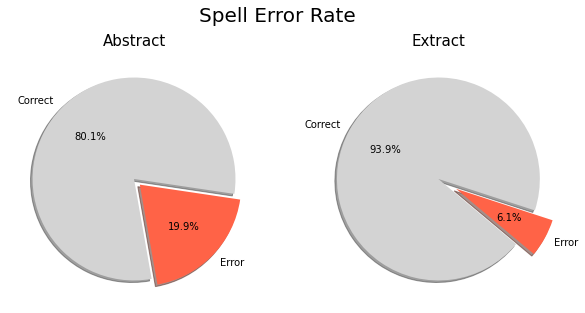

time: 82.4 ms (started: 2021-02-25 22:54:25 +09:00)


In [128]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ratio_abstract = [1-spell_error_rate_abstract, spell_error_rate_abstract]
ratio_extract = [1-spell_error_rate_extract, spell_error_rate_extract]
labels = ['Correct', 'Error']
colors = ['lightgray', '#ff6347', 'whitesmoke', 'lightgray']

ax1.pie(ratio_abstract, labels=labels, autopct='%.1f%%', startangle=2800, 
        counterclock=False, explode=[0, 0.08], shadow=True, colors=colors)
ax1.set_title('Abstract', fontsize=15)

ax2.pie(ratio_extract, labels=labels, autopct='%.1f%%', startangle=320, 
        counterclock=False, explode=[0, 0.2], shadow=True, colors=colors)
ax2.set_title('Extract', fontsize=15)

fig.patch.set_facecolor('xkcd:white')
fig.suptitle('Spell Error Rate', fontsize=20)
plt.show()

추상적 요약을 통하여 생성한 문장의 경우, 전체 단어 중 19.9% 가량에서 문법적 오류가 발견되었다. 그에 비해 추출적 요약은 6.1% 정도의 오류가 확인 되었다. 실제 문장에서 문장을 뽑아내는 것이니 원본 문장의 문장 구조(단어 배열을 순서)를 반영할 수 있었기 때문에 추출적 요약에서 문법적 오류가 더 적은 것으로 추정된다. 또한 추출적 요약의 경우, 모델의 불완전하여 문장에서 의미없이 중복되는 단어가 발견되고는 하는데( ex. player once played out of match during match match
)이 경우가 문법적 오류 비율에 큰 영향을 미쳤을 것이다.

### 3. 핵심 단어 포함 여부
- 20개의 샘플 중 5개를 선정하여 확인해 보도록하자.

In [129]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

random_idx = random.sample(range(20), 5)


def left_align(df):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

time: 742 µs (started: 2021-02-25 22:54:32 +09:00)


- 첫번째 샘플

In [131]:
df = pd.DataFrame(summary_report[random_idx[0]], index=[random_idx[0]]).T
df = left_align(df)
display(df)

,7
raw,"The Chinese government is recruiting 20,000 people to write an online encyclopedia like Wikipedia. The scholars will reportedly write more than 3,00,000 entries of about 1,000 words apiece spanning over 100 disciplines. The resource will reportedly have information on China's technological developments and historical heritage to ""strengthen the core values of socialism.Ã¢ÂÂ"
reference,china to hire people to write wikipedia like
abstract,china releases language of
f1_abstract,0.166667
extract,"The scholars will reportedly write more than 3,00,000 entries of about 1,000 words apiece spanning over 100 disciplines."
f1_extract,0.076923


time: 6.8 ms (started: 2021-02-25 22:55:17 +09:00)


원문은 *중국정부에서 위키 같은 인터넷 사전 작성을 위하여 사람을 고용하고 있다*는 내용으로 [chian, hire] 정도가 핵심 키워드라고 할 수 있다. 추상 요약에서는 완전한 문장은 아니지만 china가 포함되어 있다. 추출 요약은 위키를 어떤식으로 작성할 것인가에 대한 내용으로 원문 전체의 핵심을 담고 있다고 보기 어렵다.

- 두번째 샘플

In [133]:
df = pd.DataFrame(summary_report[random_idx[1]], index=[random_idx[1]]).T
df = left_align(df)
display(df)

,18
raw,"Authorities have arrested the suspect who fatally shot Indian-origin police officer Ronil Singh earlier this week in California, US. The suspect, Gustavo Perez Arriaga, was in the US illegally and was arrested as he tried to flee back to Mexico. Seven other people who misled the authorities about his whereabouts or aided him in fleeing were also arrested."
reference,indian origin policeman suspected killer arrested in us
abstract,indian man arrested for killing us in us
f1_abstract,0.625000
extract,Seven other people who misled the authorities about his whereabouts or aided him in fleeing were also arrested.
f1_extract,0.076923


time: 6.89 ms (started: 2021-02-25 22:57:55 +09:00)


원문은 *인도 출신 경찰관을 살해한 용의자를 체포*한 사실에 대하여 다루고 있으므로 [arrest]가 핵심 단어가 된다. 추상 요약에에서는 arrest가 포함되어 있지만, 원문과 완전히 반전된 내용을 말하고 있다. 추출 요약에서도 arrest가 등장하지만, 살해 용의자의 도주를 도왔던 다른 인물들도 체포했다는 내용을 담고 있기 때문에 핵심이 되는 부분을 표현하기 위하여 arrest를 사용하였다고 보기 어렵다.

- 세번째 샘플

In [134]:
df = pd.DataFrame(summary_report[random_idx[2]], index=[random_idx[2]]).T
df = left_align(df)
display(df)

,10
raw,"Weapons belonging to India's shooting team were seized by the customs department at Delhi airport on Tuesday, with the shooters being detained for over 13 hours. The shooters, which included a few Olympians returning from the Plzen Grand Prix, were reportedly clueless about the reason for detention. They also alleged the customs officials used foul language with them."
reference,weapons of india shooting team seized at delhi airport
abstract,saudi arabia seizes man who killed in delhi
f1_abstract,0.117647
extract,"Weapons belonging to India's shooting team were seized by the customs department at Delhi airport on Tuesday, with the shooters being detained for over 13 hours."
f1_extract,0.285714


time: 5.83 ms (started: 2021-02-25 23:02:45 +09:00)


원문은 *올림픽 사격 선수들의 무기(총)이 델리 공항 세관국에 압수되었다*는 사실에 대하여 다루고 있으므로 [customs department at Delhi airport, shooters]가 핵심 단어가 된다. 추상 요약에에서는 해당 단어가 등장하지 않았다. 추출 요약은 원문의 첫 구절을 그대로 추출하였고 이는 핵심 단어를 포함하며 원문 전체의 핵심이 되는 부분이기도 한다.

- 네번째 샘플

In [135]:
df = pd.DataFrame(summary_report[random_idx[3]], index=[random_idx[3]]).T
df = left_align(df)
display(df)

,13
raw,"Addressing a kisan rally in Uttar Pradesh's Shahjahanpur on Saturday, PM Narendra Modi said the Opposition was shedding crocodile tears and ""had no time to work on MSP hike"". ""[Our] priority is to ensure that the hard work of the farmers of this nation is respected. That's the reason several decisions have been taken to benefit sugarcane farmers,"" he added."
reference,opposition crocodile tears pm at rally in up
abstract,pm modi calls govt govt for lok sabha
f1_abstract,0.125000
extract,"""[Our] priority is to ensure that the hard work of the farmers of this nation is respected."
f1_extract,0


time: 6.99 ms (started: 2021-02-25 23:07:01 +09:00)


원문은 *25일에 있었던 Narendra Modi의 발언*에 관하여 말하고 있으므로 핵심 키원드는 [Narendra Modi]가 될 것이다. 추상 요약에서는 modi를 포함하므로 시작은 좋았으나 문장 자체가 불완전하다. 추출 요약은 Narendra Modi의 발언 일부로 Narendra Modi에 대한 언급이 존재하지 않는다.

- 다섯번째 샘플 

In [137]:
df = pd.DataFrame(summary_report[random_idx[4]], index=[random_idx[4]]).T
df = left_align(df)
display(df)

,17
raw,"The Indonesian town of Kampung Pelangi has been repainted in bright colours and decorated with 3D murals, as part of a Ã¢ÂÂ¹14.4 lakh government-funded makeover. Once considered a slum, the town has started attracting tourists. According to reports, the local government is investing more money to clean up the river and expand the project."
reference,indonesian town painted in bright colours
abstract,german village turns out of island
f1_abstract,0
extract,"The Indonesian town of Kampung Pelangi has been repainted in bright colours and decorated with 3D murals, as part of a Ã¢ÂÂ¹14.4 lakh government-funded makeover."
f1_extract,0.258065


time: 6.64 ms (started: 2021-02-25 23:12:47 +09:00)


원문은 *인도네시아의 Kampung Pelangi 마을이 벽화를 다시 칠하면서 관광객이 유치되기 시작*했다는 내용으로 [Kampung Pelangi, mural]이 핵심 키워드라고 볼 수 있다. 추상 요약에서는 해당 단어들이 등장하지 않았다. 추출 요약은 원문의 첫 구절을 그대로 추출하였고 이는 핵심 단어를 포함하며 원문 전체의 핵심이 되는 부분이기도 한다.

- 정리

In [140]:
keyword_analyze_result = {
    'is_abstract_contain_keyword' : [ 'o', 'o', 'x', 'o', 'x'],
    'is_abstract_reasonable' : [ 'x', 'x', 'x', 'x', 'x'],
    'is_extractt_contain_keyword' : [ 'x', 'o', 'o', 'o', 'o'],
    'is_extract_reasonable' : [ 'x', 'x', 'o', 'x', 'o']
}

time: 503 µs (started: 2021-02-25 23:28:44 +09:00)


In [141]:
pd.DataFrame(keyword_analyze_result)

,is_abstract_contain_keyword,is_abstract_reasonable,is_extractt_contain_keyword,is_extract_reasonable
0,o,x,x,x
1,o,x,o,x
2,x,x,o,o
3,o,x,o,x
4,x,x,o,o


time: 7.91 ms (started: 2021-02-25 23:28:45 +09:00)


추상 요약으로 만들어진 문장은 대체로 키워드를 포함하지만 문장의 의미가 원문과 맞지 않거나 문장이 완전하지 못하였다.<br/>
추출 요약으로 만들어진 문장은 대체로 키워드를 포함하고 있었지만 그 중 절반만이 요약문이라고 할 수 있는 완성도를 보였다. 

### 4. 지표를 통한 비교 

#### ROUGE F1 SCORE

테스트 데이터 셋을 기준으로 집계한 ROUGE F1 Score는 다음과 같다.
- 추상요약 : 0.2810423389849427
- 추출요약 : 0.1839122049345609

ROUGE F1 score로 보았을 때, 추상 요약이 더 좋은 성능을 보이고 있다. 하지만, 위에서 살펴본바와 같이 프로젝트에서 학습된 모델을 통한 추상 요약은 문장에서 키워드를 뽑아내는 것은 가능하나 그 문장의 온전하지 못한 경우가 많았다. 반면, 추출 요약은 원문에서 핵심이 되는 문장 자체를 거의 그대로 뽑아오기 때문에 핵심이 되는 문장 선정에 성공한다면 문장이 자체는 완전한 경향을 보였다. 그렇기에 ROUGE F1 score가 높다고 하여 추상 요약이 더 좋은 성능을 보인다고 확언 할 수 없다.

#### WMD

- setting for wmdistance

In [112]:
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]


time: 561 ms (started: 2021-02-25 22:39:10 +09:00)


[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
time: 10min 48s (started: 2021-02-25 22:39:35 +09:00)


- test

In [157]:
sentence_obama = preprocess('Obama speaks to the media in Illinois')
sentence_president = preprocess('The president greets the press in Chicago')
sentence_orange = preprocess('Oranges are my favorite fruit')
print(f'WMD - obama~president : {model.wmdistance(sentence_obama, sentence_president)}')
print(f'WMD - obama~orange : {model.wmdistance(sentence_obama, sentence_orange)}')

WMD - obama~president : 3.3741233214730024
WMD - obama~orange : 4.380239402988511
time: 2.89 ms (started: 2021-02-25 23:54:46 +09:00)


- 추출 요약과 추상요약에 대한 WMD 비교

In [153]:
distance_abstract = 0
distance_extract = 0

for i in range(20):
    sentence_raw = summary_report[i]['raw']
    sentence_abstract = summary_report[i]['abstract']
    sentence_extract = summary_report[i]['extract']
    
    distance_raw_abstract = model.wmdistance(sentence_raw, sentence_abstract)
    distance_raw_extract = model.wmdistance(sentence_raw, sentence_extract)
    
    distance_abstract += distance_raw_abstract
    distance_extract += distance_raw_extract

time: 334 ms (started: 2021-02-25 23:51:33 +09:00)


In [156]:
print(f'WMD - abstract : {distance_abstract / 20 :.4f}')
print(f'WMD - abstract : {distance_raw_extract / 20 :.4f}')

WMD - abstract : 1.0300
WMD - abstract : 0.0270
time: 516 µs (started: 2021-02-25 23:52:20 +09:00)


추출 요약으로 생성된 문장이 추상요약으로 생성 된 문장에 비해 원문에 더 가까운 것을 확인 할 수 있었다.

## STEP 3. 결론
---

### 프로젝트 평가
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

### 회고
- 아직 모델을 평가하는데 어떤 지표를 사용해야 하는지에 대한 지식이 부족함을 느꼈다. 모델을 통하여 문장을 생성하였고 이것이 한눈에 보아도 제대로 된 것이 아니지만 **얼마나** 잘못되었는지에 대하여 알고 싶었고 그 기준이 될만한 지표가 필요하였다. 이번 프로젝트에서 사용된 지표는 ROUGE로 생성된 문자열이 참조 문자열(실제 요약문)과 중복되게 가지는 단어를 기준으로 모델을 평가하는 지표였다. 하지만 이것도 완벽하다고는 생각될 수 없었던 것이 우리가 문장을 요약할 때, 기존 문장에 있는 단어를 그대로 사용하기도 하지만 다른 단어를 사용하여서 더 함축적으로 요약을 할 수도 있다. 이 경우 중복되는 단어의 수는 더 적지만,  문장이 더 잘 요약되었다고 평가하는 것이 옳다. 하지만 ROUGE는 이를 반영할 수 없기 때문에 완전한 지표는 되지 못한다고 생각된다. 그렇다면 어떻게하면 문장간의 정확한 유사도를 구할 수 있을까?
- 검색해본 바에 의하면 WMD(Word Mover's Distance)가 가장 적합해 보였다. WMD는 이전에 영화감상분석을 하면서 살펴보았던 word2vec를 기반으로하여 단어간의 유사도를 통해 문장/문서 간의 유사도를 계산하는 방식이다.  `gensim`에서 제공하는 `wmdistance`를 이용하여 간단히 수행해 볼 수 있으며 `word2vec-google-news-300`를 바로 사용할 수 있어 뉴스를 요약하는 이번 프로젝트 주제와도 궁합이 잘 맞았다.

In [28]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15208 16284 73277 ... 78900 34069 24489]
time: 4.08 ms (started: 2021-02-25 21:36:45 +09:00)


In [34]:
np.random.shuffle(indices)
print(indices)

[27623  8366 25940 ... 41924 16943 53848]
time: 2.66 ms (started: 2021-02-25 21:38:01 +09:00)


- 괴담) 마감을 위하여 데이터를 자세히 보던 중 이상한 점을 발견하게 되었다. 추출 요약문/추상 요약문/원문의 내용이 전혀 비슷하지 않았다. 이는 np.random.suffle로부터 비롯된 문제였다. np.random.suffle에서 생선된 indices에 따라 문장의 등장 순서가 변경되는데 이는 토큰화를 시키는 과정에서 문장(단어)가 등장하는 순서를 변경시킨다. 즉, indices가 달라진다면 단어 사전의 구성도 달라진다. 프로젝트는 여러날에 걸쳐서 진행되었고, 수훨한 진행을 위하여 저정해 놓고 불러와 사용한 값은 전처리 된 문장을 담은 csv와 학습된 모델이었다. 커널이 새로이 시작 될 때마다 새로운 단어 사전이 만들어졌고, 그에따라 저장된 모델은 무용지물이 되었다. 하필이면 np.random.suffle은 seed도 지정할 수 없어 보기드물게 정말 ^랜덤^한 결과를 보여 주었기에 suffle이 진행된 이후의 데이터를 저장해 두지 않으면 사실상 다른 값들을 저장하는 것은 아무의미가 없던 것이었다. 추상적 요약의 ROUGE f1 score를 계산할적에 데이터를 건드린적이 없어 한 번에 f1 score를 다시 계산할 필요가 없었던 것이 너무 다행이었다. 세기간짜리 계산을 또 해야했다면 눈물이 찔끔 나왔을 것이다. 오랜만에 여유로웠던 마감시간에 벼락을 맞아버렸고, 지금 회고가 평소보다 아주 긴 이유도 급하게 새로 모델을 새로 돌리면서 시간이 많이 남게 되어서이다. 괜히 많은 예시들에서 train_test_split를 사용하는 것이 아님을 절감하여 다시는 한번 수행하는 것으로 끝나지 않을 프로젝트에 np.random.suffle를 사용하여 데이터를 섞는 행위를 하지 않아야겠다고 다짐하게 되었다.

## ref
---
- [예시를 통한 ROUGE 성능 지표의 이해](https://huffon.github.io/2019/12/07/rouge/)
- [Text Generation Evaluation 06 - ROUGE](https://ai-information.blogspot.com/2019/04/text-generation-evaluation-06-rouge.html)
- [How to Compute Sentence Similarity Using BERT and Word2Vec](https://towardsdatascience.com/how-to-compute-sentence-similarity-using-bert-and-word2vec-ab0663a5d64)
- [From Word Embeddings To Document Distances](http://proceedings.mlr.press/v37/kusnerb15.pdf)
- [Word Mover’s Distance in Python](http://vene.ro/blog/word-movers-distance-in-python.html)
- [[카카오AI리포트]최신 AI 논문: 데이터 - 브런치](https://brunch.co.kr/@kakao-it/139)
- [자동 요약 기법의 연구 동향 정리](https://bab2min.tistory.com/625)